# Analysis of serial HPO for LGBM

The goal is to understand how much HPO affect drug response prediction and LC plots.<br>
We executed per-subset HPO (PS-HPO). We then extracted largest-subset HPO (LS-HPO) from the PS-HPO results.

Conclusion:
1. HPO indeed affects drug response prediction with LightGBM. Thus, it's important to perform HPO when comparing models with baselines!
2. So far, we analyzed LC data from CCLE. Some shards (and most importantly the last one) use edge HPs. The fits are not that good! Repeat HPO for the final shard with higher range of HPs!
3. 

In [51]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# Make all python scripts available in the path
sys.path.append('../')

import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/vol/ml/apartin/projects/LearningCurves/notebooks


### Utils

In [52]:
def top_n_runs(df, tr_size=None, n=10, sort_by_metric='mean_absolute_error', plot=False):
    """ Return top runs based on sort_by_metric. """
    if tr_size is not None:
        df = df[df['tr_size']==tr_size].reset_index(drop=True)
    if sort_by_metric == 'r2':
        df = df.sort_values(sort_by_metric, ascending=False).iloc[:n, :]
    else:
        df = df.sort_values(sort_by_metric, ascending=True).iloc[:n, :]
    
    if plot: display(df.transpose())
    return df.reset_index(drop=True)

## Load results from runs

In [89]:
# HPO runs base dir
base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ccle/hpo_lgbm/trn.ccle/split_on_none')
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/hpo_lgbm/trn.gdsc/split_on_none')
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/hpo_lgbm/trn.ctrp/split_on_none')

In [90]:
# Load
hp = pd.read_csv( base_dir/'hpo_all.csv' )

In [91]:
# Subset of columns
if 'nn' in str(base_dir):
    col_subset = ['tr_size',
                  'batch_size', 'lr', 'opt', 'dr_rate', 'batchnorm', # HPs
                  'epoch_stop', 'epochs',
                  'run_id',
                  # 'clr_mode', 'cv_method', 'scaler',   # potential DL HPs
                  # 'n_trees',  # potential LGBM HPs
                  # 'cell_fea', 'drug_fea', 'target_name',  # features and response
                  # 'framework', 'model_name', 'cv_folds',  # ML settings
                  'shard_step_scale', # Other
                  'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2', # scores
                 ]
else:
    col_subset = ['tr_size',
                  'gbm_leaves', 'gbm_lr', 'gbm_max_depth', 'gbm_trees', # HPs
                  'run_id',
                  # 'n_trees',  # potential LGBM HPs
                  # 'cell_fea', 'drug_fea', 'target_name',  # features and response
                  # 'framework', 'model_name', 'cv_folds',  # ML settings
                  'shard_step_scale', # Other
                  'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2', # scores
                 ]

In [92]:
# Cols subset
hp = hp[[c for c in col_subset if c in hp.columns]]
print(hp.shape)
hp[:2]

(1008, 9)


,tr_size,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,shard_step_scale,mean_absolute_error,median_absolute_error,r2
0,1024,31,0.1,-1,100,log2,0.065714,0.055311,0.708949
1,128,31,0.1,-1,100,log2,0.077981,0.062363,0.587340


### Check data

In [93]:
# Certain runs were not completed --> check
hp['tr_size'].value_counts().reset_index().rename(columns={'index': 'subset'}).sort_values('subset').reset_index(drop=True)

,subset,tr_size
0,128,144
1,256,144
2,512,144
3,1024,144
4,2048,144
5,4096,144
6,7806,144


In [94]:
# certain runs were not completed (a more detailed look)
if 'nn' in str(base_dir):
    display(hp.groupby(['tr_size', 'batch_size']).agg({'r2': 'size'}).reset_index().rename(columns={'r2': 'count'})[:10])

In [95]:
# All HP per subset size
if 'nn' in str(base_dir):
    display(hp.groupby('tr_size').agg({'batch_size': 'unique', 'dr_rate': 'unique', 'opt': 'unique', 'lr': 'unique',
                               'mean_absolute_error': 'min', 'r2': 'max'}).reset_index())
elif 'lgbm' in str(base_dir):
    display(hp.groupby('tr_size').agg({'gbm_leaves': 'unique', 'gbm_lr': 'unique', 'gbm_max_depth': 'unique', 'gbm_trees': 'unique',
                               'mean_absolute_error': 'min', 'r2': 'max'}).reset_index())

,tr_size,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,mean_absolute_error,r2
0,128,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.077981,0.588151
1,256,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.068188,0.688726
2,512,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.066863,0.698606
3,1024,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.063541,0.727919
4,2048,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.062162,0.734060
5,4096,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.059969,0.751394
6,7806,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.055895,0.786365


In [96]:
# Certain runs were did not converge (early stop was not activated)
if 'nn' in str(base_dir):
    not_cnv = hp[ hp['epoch_stop']==hp['epochs'] ]
    print('Early stop was not activated for {} runs out of {}'.format( not_cnv.shape[0], hp.shape[0] ))

### Plot all LD data points across HPO runs

In [97]:
met = 'mean_absolute_error'

# Plot settings
figsize=(6, 4.5)
# xtick_scale, ytick_scale = 'linear', 'linear'
xtick_scale, ytick_scale = 'log2', 'log2'

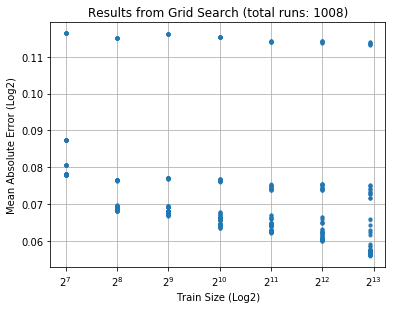

In [98]:
fig, ax = plt.subplots(figsize=figsize)
plt.plot(hp['tr_size'], hp[met], '.', alpha=0.5); plt.grid(True); plt.xlabel('Train Size (Log2)'); plt.ylabel(lrn_crv_plot.capitalize_metric(met) + ' (Log2)');
ax.set_title('Results from Grid Search (total runs: {})'.format(hp.shape[0]))
ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)

## Compare PS-HPO and LS-HPO

In [99]:
plot_kwargs = {'plot_fit': True, 'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

### PS-HPO
Extract the best performance score for every shard (for each metric)

In [100]:
ps_best = hp.sort_values(met, ascending=True).drop_duplicates(['tr_size']).sort_values('tr_size').reset_index(drop=True)
ps_best

,tr_size,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,shard_step_scale,mean_absolute_error,median_absolute_error,r2
0,128,50,0.10,-1,2000,log2,0.077981,0.062363,0.587340
1,256,10,0.01,10,2000,log2,0.068188,0.055129,0.687196
2,512,10,0.10,5,100,log2,0.066863,0.054101,0.698606
3,1024,10,0.01,10,2000,log2,0.063541,0.052463,0.727919
4,2048,10,0.10,5,1000,log2,0.062162,0.050084,0.733053
5,4096,31,0.10,10,1000,log2,0.059969,0.047646,0.750254
6,7806,50,0.01,-1,2000,log2,0.055895,0.044855,0.785273


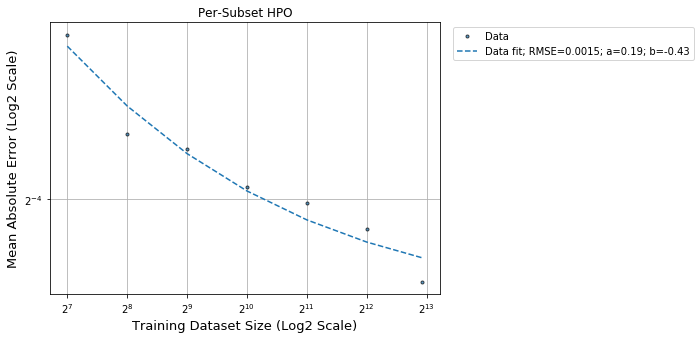

In [65]:
lrn_crv_plot.plot_lrn_crv_power_law( x = ps_best['tr_size'], y = ps_best[met], title='Per-Subset HPO', **plot_kwargs );

### LS-HPO
Extract the best performance score for the largest shard (for each metric)

In [66]:
best = top_n_runs(hp, tr_size=hp['tr_size'].max(), n=1, sort_by_metric=met, plot=False)
display(best)

,tr_size,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,shard_step_scale,mean_absolute_error,median_absolute_error,r2
0,7806,50,0.01,-1,2000,log2,0.055895,0.044855,0.785273


In [68]:
if 'nn' in str(base_dir):
    prm_names = ['dr_rate', 'opt', 'lr', 'batchnorm', 'batch_size']
elif 'lgbm' in str(base_dir):
    prm_names = ['gbm_trees', 'gbm_max_depth', 'gbm_lr', 'gbm_leaves']

In [69]:
idx = pd.Series(True, index=range(hp.shape[0]))
for c in prm_names:
    idx = idx & ( hp[c] == best[c][0] )
    
ls_best = hp[ idx ].sort_values('tr_size').reset_index(drop=True)

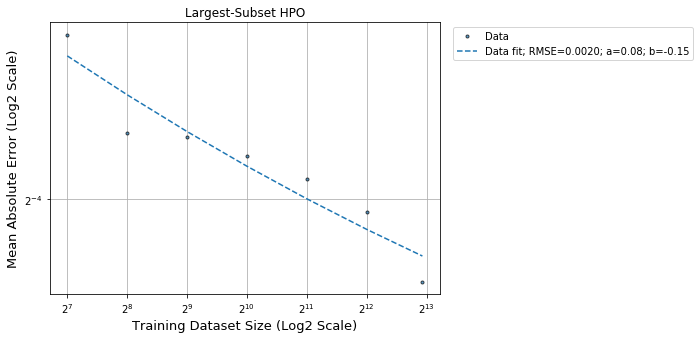

In [70]:
lrn_crv_plot.plot_lrn_crv_power_law( x = ls_best['tr_size'], y = ls_best[met], title='Largest-Subset HPO', **plot_kwargs );

### PS-HPO vs LS-HPO fit

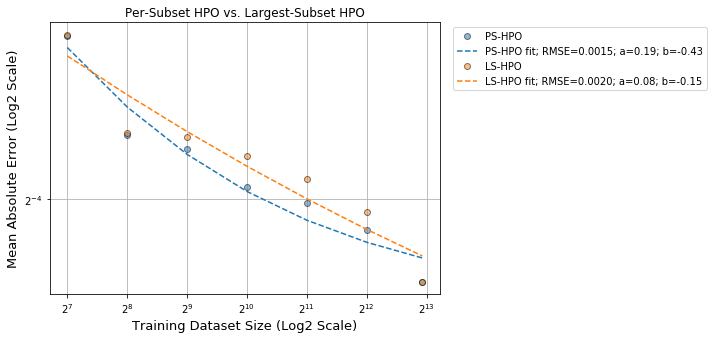

In [73]:
marker='o'; alpha=0.5

ax, fit_prms, rmse = lrn_crv_plot.plot_lrn_crv_power_law(x=ps_best['tr_size'], y=ps_best[met],
                                                         marker=marker, alpha=alpha, label='PS-HPO',
                                                         ax=None, **plot_kwargs)

ax, fit_prms, rmse = lrn_crv_plot.plot_lrn_crv_power_law(x=ls_best['tr_size'], y=ls_best[met],
                                                         marker=marker, alpha=alpha, label='LS-HPO', 
                                                         ax=ax, **plot_kwargs,
                                                         title='Per-Subset HPO vs. Largest-Subset HPO')

## PS-HPO vs LS-HPO extrapolate

In [74]:
m0 =6

(<matplotlib.axes._subplots.AxesSubplot at 0x7f033f17b9e8>,
 {'alpha': 1.0618241313984353,
  'beta': -0.8757321117355314,
  'gamma': 0.062306768484380534})

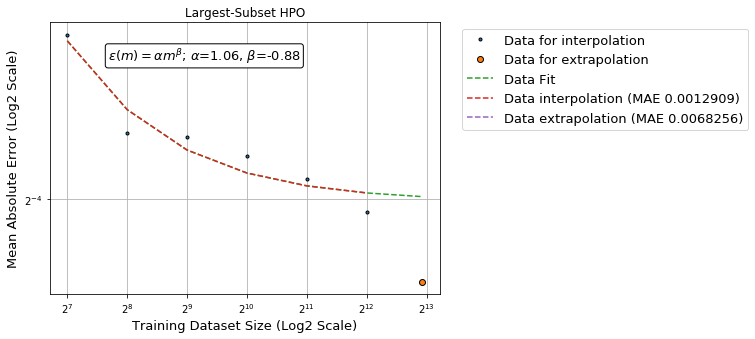

In [75]:
lrn_crv_plot.lrn_crv_power_law_extrapolate(x=ls_best['tr_size'], y=ls_best[met],
                                           m0=m0, **plot_kwargs, title='Largest-Subset HPO')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f033f4aa0f0>,
 {'alpha': 0.8969839218017783,
  'beta': -0.8096093306630971,
  'gamma': 0.05983705163684592})

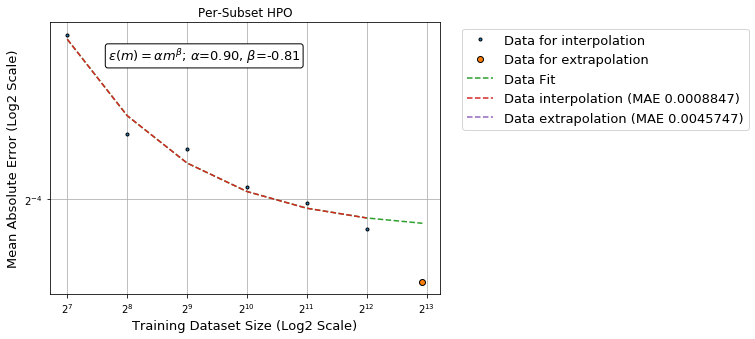

In [76]:
lrn_crv_plot.lrn_crv_power_law_extrapolate(x=ps_best['tr_size'], y=ps_best[met],
                                           m0=m0, **plot_kwargs, title='Per-Subset HPO')